In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek



## 1. Carga de datos

In [4]:

data = pd.read_csv('df_con_grid.csv')


## 2. Filtrar datos

Se eliminan los datos que no pertenecen a la comunidad valenciana y que son dependientes de de la longuitud y la latitud.
Alguno de los datos que quedan pueden ser de otra comunidad dado que limitamos en cuadrado y la comunidad valenciana no es un rectangulo si no que tiene entradas y salidas del terreno

In [12]:
data = data.replace({',': ''}, regex=True)



Datos originales: (10526, 168)
Datos filtrados: (10526, 168)


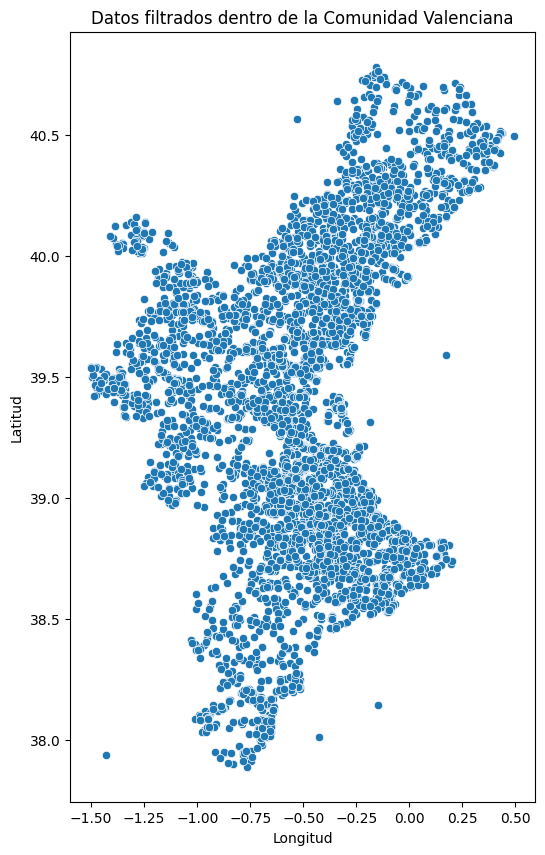

In [ ]:
# Se incluyen únicamente los datos que estan dentro de las coordenadas correctas de la comunidad valenciana
data_filtrado = data[
    (data['Latitude'] <= 42) & (data['Latitude'] >= 36) &  # Latitude
    
    (data['Longitude'] <= 0.6) & (data['Longitude'] >= -1.7)  # Longitude
]

print(f"Datos originales: {data.shape}")
print(f"Datos filtrados: {data_filtrado.shape}")

# Gráfico
plt.figure(figsize=(6,10))
sns.scatterplot(data=data_filtrado, x='Longitude', y='Latitude')
plt.title("Datos filtrados dentro de la Comunidad Valenciana")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


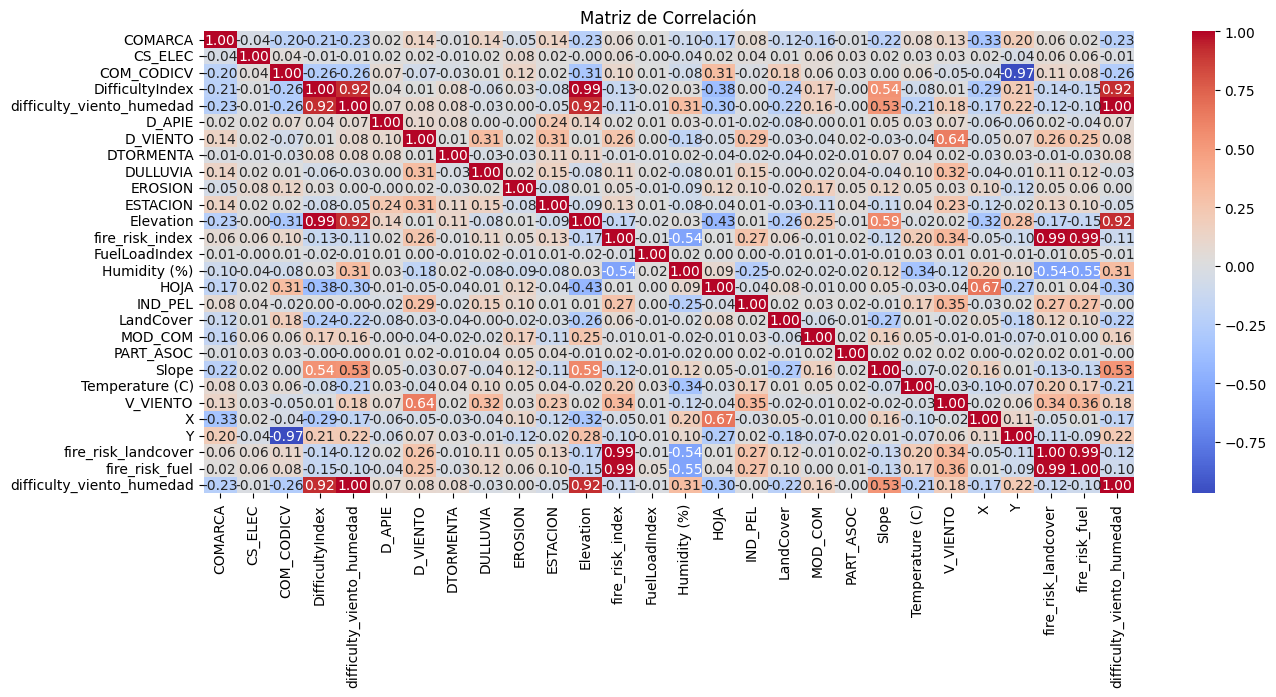

In [15]:
var = data_filtrado[['COMARCA','CS_ELEC','COM_CODICV','DifficultyIndex','difficulty_viento_humedad','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]


plt.figure(figsize=(15, 6))
correlation_matrix = var.corr(method= 'spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


Elimino Elevación de la primeras variables a estudiar, porque tiene mucha relacion con el `DifficultyIndex` ya que este se calcula con la ``elevacion``,``LandCoverIndex`` y el ``Slope``. 

El `DifficultyIndex` y el `fire_resk_index` los quitaremos también porque hemos desarrollado a partir de ellos otras variables más especificas

Tambien quitarémos en los modelos ``D_Viento`` o  ``V_Viento`` dependiendo del estudio de importancia previo a hacer el `.fit` en el modelo 

Con las coordenadas también puedo quitar `'COM_CODICV'`, `HOJA`



In [ ]:
data_filtrado = data_filtrado[['COMARCA','CS_ELEC','difficulty_viento_humedad','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover','fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y']]

Para los datos que estan muy desbalanceados (caso de los BULDOZZER) hacemos un tratamiento de los datos para poder mejorar la clase minoritaria

In [ ]:
data_imputer = data_filtrado['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad','BULDOZZER_CLASS']

In [ ]:
# Define imputer
num_imputer = SimpleImputer(strategy='median')

# Select numerical columns
num_cols = data_imputer.select_dtypes(include=['float64', 'int']).columns

# Transform numerical columns
transformed_array = num_imputer.fit_transform(data_imputer[num_cols])

# Construct a DataFrame for the transformed data
transformed_data = pd.DataFrame(
    transformed_array,
    columns=num_cols,  # Use all selected numerical columns
    index=data_imputer.index  # Maintain original DataFrame index
)

# Assign back to the original DataFrame
data_imputer[num_cols] = transformed_data


In [ ]:
X = data_imputer[['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = data_imputer[ 'BULDOZZER_CLASS']

In [ ]:

smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X, y)

# Crear un nuevo DataFrame balanceado
balanced_df = pd.DataFrame(X_resampled, columns=['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad'])
balanced_df['BULDOZZER_CLASS' ] = y_resampled
